In [1]:
# ================= Standard Libraries =================
import time
from collections import Counter
from IPython.display import clear_output, display, Math, Markdown
import warnings


# ================= Data Handling ======================
import pandas as pd
import numpy as np
import os

# ================= Visualization =======================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ================= Scikit-Learn ========================
from sklearn import preprocessing, decomposition, cluster, metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances_argmin_min, mean_absolute_percentage_error, mean_squared_error

# ================= Statsmodels =========================
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot, ProbPlot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# ================= SciPy Stats =========================
from scipy.stats import shapiro, kruskal
import scipy.stats as st

# ================= Prediction Stats =========================
from pmdarima import auto_arima

In [2]:
# Le MAPE (Mean Absolute Percentage Error) est un chiffre qui te dit √† quel point un mod√®le de pr√©vision s'est tromp√©, en pourcentage.
def mape(y_true, y_pred):
    erreur = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    precision = 100 - erreur
    return print(f"Pr√©cision du mod√®le : {precision:.2f}%")

###¬†Mise en situation
Vous √™tes employ√© chez Enercoop, soci√©t√© coop√©rative qui s'est d√©velopp√©e gr√¢ce √† la lib√©ralisation du march√© de l‚Äô√©lectricit√© en France. Elle est sp√©cialis√©e dans les √©nergies renouvelables.

Les √©nergies renouvelables : des sources in√©puisables et r√©utilisables
Selon la d√©finition de l‚ÄôINSEE, les √©nergies renouvelables sont les ¬´ √©nergies d√©riv√©es de processus naturels en perp√©tuel renouvellement, notamment celles d‚Äôorigine solaire, √©olienne, hydraulique, g√©othermique ou v√©g√©tale ¬ª. 

Plus simplement, les √©nergies d‚Äôorigine renouvelables sont issues des √©l√©ments naturels : le soleil, le vent, les chutes d‚Äôeau, les mar√©es, la chaleur de la Terre, la croissance des v√©g√©taux‚Ä¶ Souvent, on qualifie les √©nergies renouvelables d‚Äô√©nergies ‚Äúflux‚Äù par opposition aux √©nergies ‚Äústock‚Äù, elles-m√™mes constitu√©es de gisements limit√©s de combustibles fossiles (p√©trole, charbon, gaz, uranium). Contrairement √† celle des √©nergies fossiles, l‚Äôexploitation des √©nergies renouvelables n‚Äôengendre pas ou peu de d√©chets et d‚Äô√©missions polluantes. 

La plupart de ces √©nergies renouvelables est cependant intermittente, il est donc difficile de pr√©voir les capacit√©s de production d'√©lectricit√©. De plus, la demande en √©lectricit√© des utilisateurs varie au cours du temps, et d√©pend de param√®tres comme la m√©t√©o (temp√©rature, luminosit√©, etc.) Tout le challenge est de mettre en ad√©quation l'offre et la demande !

###¬†Mission
Vous vous concentrerez uniquement sur la pr√©diction de la demande en √©lectricit√©.

- Corrigez les donn√©es de consommation mensuelles de l'effet temp√©rature (dues au chauffage √©lectrique) en utilisant une r√©gression lin√©aire.
- Effectuez une d√©saisonnalisation de la consommation que vous aurez obtenue apr√®s correction, gr√¢ce aux moyennes mobiles.
- Effectuez une pr√©vision de la consommation (corrig√©e de l'effet temp√©rature) sur un an, en utilisant la m√©thode de Holt Winters (lissage -exponentiel) puis la m√©thode SARIMA sur la s√©rie temporelle.

#### Dataset consommation d'√©n√©rgies 

In [3]:
dataConso = pd.read_csv("resources/data/data_conso.csv", parse_dates=True)
dataConso.head()

date  consommation  prevision_j1  prevision_j    fioul  charbon  \
0  2012-01-01     2471592.0     4901850.0    4841050.0  23649.0    758.0   
1  2012-01-02     2912815.0     5796450.0    5739050.0  23598.0    378.0   
2  2012-01-03     3252581.0     6349550.0    6392550.0  24700.0    205.0   
3  2012-01-04     3265403.0     6455450.0    6430900.0  26208.0      7.0   
4  2012-01-05     3319555.0     6410150.0    6484500.0  25809.0     16.0   

        gaz  nucleaire    eolien  solaire  hydraulique  pompage  bioenergies  
0  181778.0  2153346.0  188459.0   6255.0     367472.0 -86821.0      33411.0  
1  194404.0  2557111.0  147353.0   4267.0     412364.0 -50571.0      31219.0  
2  193376.0  2794380.0  228569.0   6768.0     484559.0 -48850.0      31888.0  
3  178234.0  2767347.0  203392.0   8655.0     490193.0 -42190.0      32737.0  
4  203859.0  2712466.0  249564.0   3207.0     516675.0 -40085.0      32991.0

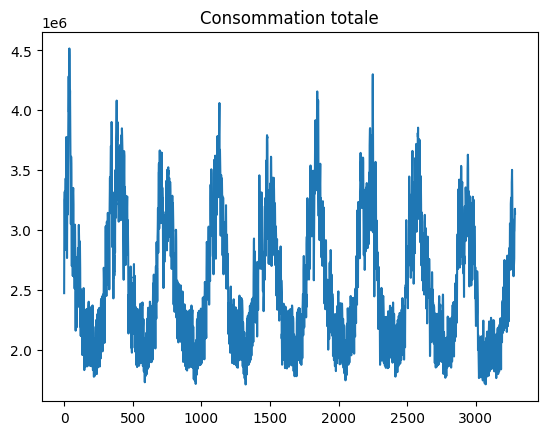

In [4]:
plt.plot(dataConso.consommation)
plt.title("Consommation totale")
plt.show()

In [5]:
conso = dataConso.copy()

# Convertir la colonne 'date' en datetime
conso["date"] = pd.to_datetime(conso["date"])

# Ajouter une colonne 'mois' en format p√©riode (ann√©e-mois)
conso["mois"] = conso["date"].dt.to_period("M")
# Grouper par 'mois' et sommer uniquement les colonnes num√©riques
monthConso = conso.groupby('mois', as_index=False).sum(numeric_only=True)
monthConso['mois'] = monthConso['mois'].dt.to_timestamp()
monthConso.head(2)

mois  consommation  prevision_j1  prevision_j      fioul    charbon  \
0 2012-01-01   101573076.0   201985150.0  201244900.0   893223.0  1537770.0   
1 2012-02-01   108364070.0   217363100.0  216323300.0  2070743.0  5111869.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   
1  9966798.0  77305538.0  2242160.0  404651.0   10405047.0  -835944.0   

   bioenergies  
0    1039213.0  
1     924169.0

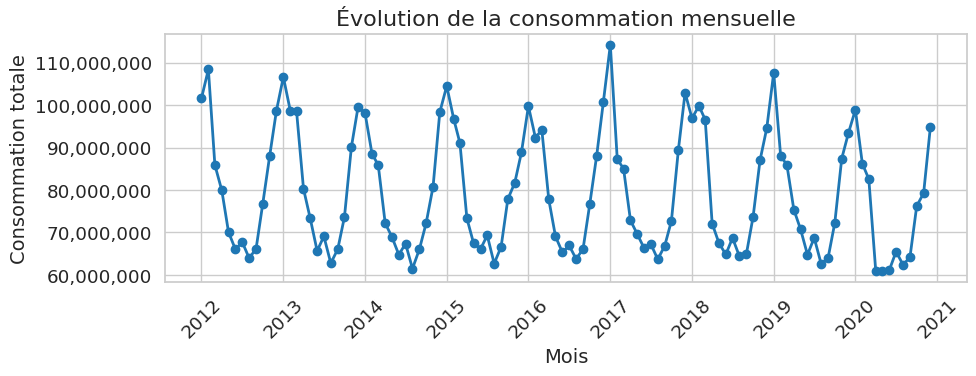

In [6]:
sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 4))
plt.plot(monthConso['mois'], monthConso['consommation'], marker='o', color='tab:blue', linewidth=2)

plt.title('√âvolution de la consommation mensuelle', fontsize=16)
plt.xlabel('Mois', fontsize=14)
plt.ylabel('Consommation totale', fontsize=14)

# Formater l'affichage des dates sur l'axe x
date_form = DateFormatter("%Y")
ax = plt.gca()
ax.xaxis.set_major_formatter(date_form)

# Formater l'axe y pour afficher des nombres entiers complets sans notation scientifique
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('resources/img/consommations.png', transparent=True)
plt.show()

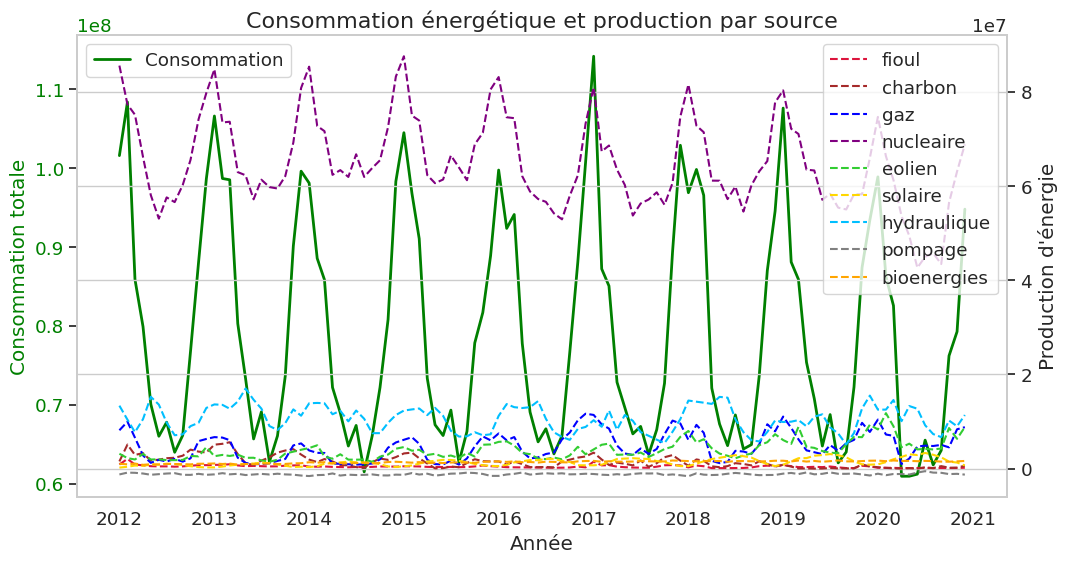

In [7]:
monthConso['mois'] = pd.to_datetime(monthConso['mois'])

energies = ["fioul", "charbon", "gaz", "nucleaire", "eolien", "solaire", "hydraulique", "pompage", "bioenergies"]

# D√©finir une palette de couleurs
colors = ["crimson", "brown", "blue", "purple", "limegreen", "gold", "deepskyblue", "gray", "orange"]

# Cr√©ation de la figure et des axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Tracer la consommation totale
ax1.plot(monthConso['mois'], monthConso['consommation'], label="Consommation", color="green", linewidth=2)
ax1.set_xlabel("Ann√©e")
ax1.set_ylabel("Consommation totale", color="green")
ax1.tick_params(axis='y', labelcolor="green")
ax1.grid()

ax2 = ax1.twinx()
ax2.set_ylabel("Production d'√©nergie")
for source, colorPal in zip(energies, colors):
    ax2.plot(monthConso['mois'], monthConso[source], label=source, color=colorPal, linewidth=1.5, linestyle="--")

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.title("Consommation √©nerg√©tique et production par source", fontsize=16)
plt.savefig('resources/img/consommations_energies.png', transparent=True)
plt.show()

####¬†DJU D√©finition

Le degr√© jour est une valeur repr√©sentative de la diff√©rence entre la temp√©rature d‚Äôune journ√©e donn√©e et un seuil de temp√©rature de r√©f√©rence (18 ¬∞C dans le cas des DJU ou Degr√© Jour Unifi√©). Somm√©s sur une p√©riode, ces √©carts permettent de calculer les besoins de chauffage et de climatisation d‚Äôun b√¢timent.

Ils permettent d‚Äôestimer la consommation d‚Äô√©nergie pour le chauffage, de comparer les hivers d‚Äôune ann√©e √† l‚Äôautre et d‚Äôanticiper la demande en √©nergie.

Plus simplement plus les DJU sont √©lever plus il fait froid. Dans notre dataset il faut comprendre que c'est le cumul des d√©gres par jours 


In [8]:
# donnnee du chauffage
dju = pd.read_excel("resources/data/calcul_DJU.xlsx", header=None, skiprows=10)
dju.head(2)

0      1      2      3      4      5      6      7      8   \
0       STATIONS  ANNEE    JAN    F√âV    MAR    AVR    MAI    JUN    JUI   
1  01 - AMBERIEU   2022  890.8  663.6  651.6  585.8  382.4  253.2  249.7   

      9      10     11   12     13     14  
0    AO√õ    SEP    OCT  NOV    D√âC  Total  
1  232.1  409.8  587.4  599  746.7   6252

In [9]:
dju.columns = [
    "STATIONS", "ANNEE", "JAN", "F√âV", "MAR", "AVR", "MAI", "JUN",
    "JUI", "AO√õ", "SEP", "OCT", "NOV", "D√âC", "TOTAL"
]

# Si la colonne TOTAL n'est pas correcte ou absente, la recalculer
dju["TOTAL"] = dju[["JAN", "F√âV", "MAR", "AVR", "MAI", "JUN", "JUI", "AO√õ", "SEP", "OCT", "NOV", "D√âC"]].sum(axis=1)

# Conversion des mois en colonnes num√©riques 
month_map = {
    "JAN": 1, "F√âV": 2, "MAR": 3, "AVR": 4, "MAI": 5, "JUN": 6,
    "JUI": 7, "AO√õ": 8, "SEP": 9, "OCT": 10, "NOV": 11, "D√âC": 12
}

dju.rename(columns=month_map, inplace=True)
dju = dju.iloc[1:].reset_index(drop=True)
djuGlobal = dju.copy()
dju.head(2)

STATIONS ANNEE      1      2      3      4      5      6      7  \
0  01 - AMBERIEU  2022  890.8  663.6  651.6  585.8  382.4  253.2  249.7   
1  01 - AMBERIEU  2021  865.1  629.9  700.4  619.1  535.8  299.1  328.1   

       8      9     10     11     12   TOTAL  
0  232.1  409.8  587.4    599  746.7  6252.1  
1  350.1  348.8  585.5  760.6    817  6839.5

In [10]:
stations = dju["STATIONS"].unique()
stations

array(['01 - AMBERIEU', '02 - ST QUENTIN', '03 - VICHY-CHARMEIL',
       '04 - ST AUBAN', '05 - EMBRUN', '06 - CANNES', '06 - NICE',
       '07 - LANAS SYN', '08 - CHARLEVILLE-MEZ', '09 - ST GIRONS',
       '10 - TROYES-BARBEREY', '11 - CARCASSONNE', '12 - MILLAU',
       '13 - AIX EN PROVENCE', '13 - MARSEILLE', '14 - CAEN-CARPIQUET',
       '15 - AURILLAC', '16 - COGNAC', '17 - LA ROCHELLE AERODROME',
       '18 - BOURGES', '19 - BRIVE', '21 - DIJON-LONGVIC',
       '22 - ST BRIEUC', '23 - GUERET-ST LAURENT', '24 - BERGERAC',
       '25 - BESANCON', '26 - MONTELIMAR', '27 - EVREUX-HUEST',
       '28 - CHARTRES', '29 - BREST-GUIPAVAS', '30 - NIMES-COURBESSAC',
       '31 - TOULOUSE-BLAGNAC', '32 - AUCH', '33 - BORDEAUX-MERIGNAC',
       '33 - LEGE-CAP-FERRET', '34 - MONTPELLIER',
       '35 - RENNES-ST JACQUES', '36 - CHATEAUROUX  DEOLS', '37 - TOURS',
       '38 - GRENOBLE-ST GEOIRS', '39 - LONS LE SAUNIER', '40 - DAX',
       '41 - BLOIS', '42 - ST ETIENNE-BOUTHEON', '43 - LE PUY-LO

In [11]:
# V√©rification des colonnes
monthColumn = [col for col in range(1, 13) if col in dju.columns]
print("Month Columns:", monthColumn)
if not monthColumn:
    monthColumn = [str(col) for col in range(1, 13) if str(col) in dju.columns]
    print("String Month Columns:", monthColumn)

# S√©lection des colonnes
selectedColumn = ["STATIONS", "ANNEE"] + monthColumn
print("Selected Columns:", selectedColumn)

# Filtre DataFrame
djuFilter = dju[selectedColumn]
print("Filtered DataFrame Shape:", djuGlobal.shape)

# Transforming into long format
djuCleared = djuFilter.melt(id_vars=["STATIONS", "ANNEE"], var_name="mois", value_name="chauffage")
print("After Melting Shape:", djuGlobal.shape)
print(djuCleared.head())

# V√©rification 
print("Final DataFrame:")
djuCleared.head()

Month Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Selected Columns: ['STATIONS', 'ANNEE', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Filtered DataFrame Shape: (1100, 15)
After Melting Shape: (1100, 15)
        STATIONS ANNEE mois chauffage
0  01 - AMBERIEU  2022    1     890.8
1  01 - AMBERIEU  2021    1     865.1
2  01 - AMBERIEU  2020    1     794.4
3  01 - AMBERIEU  2019    1       862
4  01 - AMBERIEU  2018    1     695.7
Final DataFrame:


STATIONS ANNEE mois chauffage
0  01 - AMBERIEU  2022    1     890.8
1  01 - AMBERIEU  2021    1     865.1
2  01 - AMBERIEU  2020    1     794.4
3  01 - AMBERIEU  2019    1       862
4  01 - AMBERIEU  2018    1     695.7

In [12]:
# Transformer le DataFrame 'djuCleared' en format long
dataChauffageCleared = djuCleared.reset_index().melt(id_vars=["STATIONS", "ANNEE", "mois"], value_vars=["chauffage"], var_name="variable", value_name="valeur")

# Renommer les colonnes pour plus de clart√©
# Convert mois to string if it's not already
dataChauffageCleared["mois"] = dataChauffageCleared["mois"].astype(str)

# Cr√©er la colonne date
dataChauffageCleared["date"] = pd.to_datetime(dataChauffageCleared["ANNEE"].astype(str) + "-" + dataChauffageCleared["mois"].str.zfill(2) + "-01")

# S√©lectionner uniquement les colonnes n√©cessaires
dataChauffageCleared = dataChauffageCleared[["STATIONS",'date', 'valeur']]  # Change 'chauffage' to 'valeur'

# Sauvegarder si n√©cessaire
dataChauffageCleared.to_csv("resources/data/valid/chauffage_cleared.csv", index=False)
dataChauffageCleared.head()

STATIONS       date valeur
0  01 - AMBERIEU 2022-01-01  890.8
1  01 - AMBERIEU 2021-01-01  865.1
2  01 - AMBERIEU 2020-01-01  794.4
3  01 - AMBERIEU 2019-01-01    862
4  01 - AMBERIEU 2018-01-01  695.7

In [13]:
chauffage = pd.read_csv("resources/data/valid/chauffage_cleared.csv", parse_dates=True)
chauffage.head()

STATIONS        date  valeur
0  01 - AMBERIEU  2022-01-01   890.8
1  01 - AMBERIEU  2021-01-01   865.1
2  01 - AMBERIEU  2020-01-01   794.4
3  01 - AMBERIEU  2019-01-01   862.0
4  01 - AMBERIEU  2018-01-01   695.7

######¬†Il manque des villes mais aussi orly est dans le 94 et non dans le 91
Il manque la seine saint denis  (93) et les dom-tom

Nous devons s√©lectionner un d√©partement afin d'√©voluer plus simplement dans les recherches.

In [14]:
dju_paris = chauffage[chauffage['STATIONS'] == '75 - PARIS-MONTSOURIS'].copy()
# S'assurer que la colonne "date" est bien en datetime
dju_paris["date"] = pd.to_datetime(dju_paris["date"])
dju_paris.rename(columns={'valeur': 'chauffage_dju'}, inplace=True)
dju_paris.head(2)

STATIONS       date  chauffage_dju
869  75 - PARIS-MONTSOURIS 2022-01-01          757.4
870  75 - PARIS-MONTSOURIS 2021-01-01          768.7

In [15]:
monthConso.rename(columns={'mois': 'date'}, inplace=True)

In [16]:
consommations = pd.merge(monthConso, dju_paris, on='date', how='left')
consommations['date'] = pd.to_datetime(consommations['date'])
consommations['chauffage_dju'] = consommations['chauffage_dju'].fillna(0)
consommations.head(2)

date  consommation  prevision_j1  prevision_j      fioul    charbon  \
0 2012-01-01   101573076.0   201985150.0  201244900.0   893223.0  1537770.0   
1 2012-02-01   108364070.0   217363100.0  216323300.0  2070743.0  5111869.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   
1  9966798.0  77305538.0  2242160.0  404651.0   10405047.0  -835944.0   

   bioenergies               STATIONS  chauffage_dju  
0    1039213.0  75 - PARIS-MONTSOURIS          708.0  
1     924169.0  75 - PARIS-MONTSOURIS          783.9

In [17]:
consommationsEmpty = consommations['chauffage_dju'] == 0
print(consommationsEmpty[consommationsEmpty])

Series([], Name: chauffage_dju, dtype: bool)


In [18]:
consommations.isna().any()

date             False
consommation     False
prevision_j1     False
prevision_j      False
fioul            False
charbon          False
gaz              False
nucleaire        False
eolien           False
solaire          False
hydraulique      False
pompage          False
bioenergies      False
STATIONS         False
chauffage_dju    False
dtype: bool

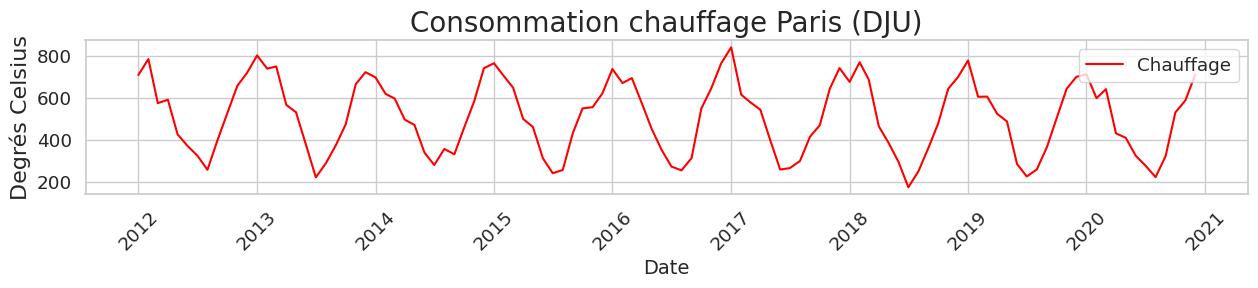

In [19]:
consommations["date"] = pd.to_datetime(consommations["date"])
# Tracer le graphique
plt.figure(figsize=(15, 2))
plt.title("Consommation chauffage Paris (DJU)", fontsize=20)
plt.plot(consommations["date"], consommations["chauffage_dju"], label="Chauffage", color="red")
# √âtiquettes des axes
plt.xlabel("Date", fontsize=14)
plt.ylabel("Degr√©s Celsius", fontsize=16)
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
# Affichage du graphique
plt.show()


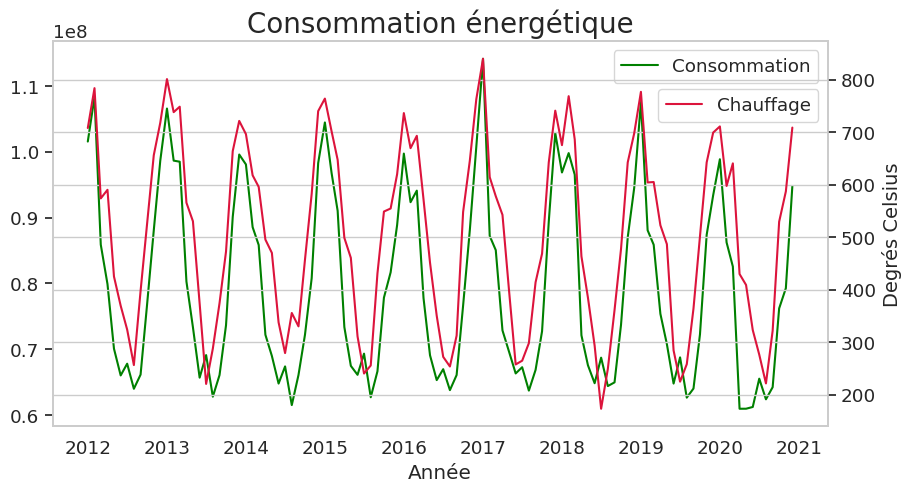

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(consommations['date'], consommations['consommation'], label="Consommation", color="green")
ax1.set_xlabel("Ann√©e")
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(consommations['date'], consommations['chauffage_dju'], label="Chauffage", color="crimson")
ax2.set_ylabel("Degr√©s Celsius", fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

plt.title("Consommation √©nerg√©tique", fontsize=20)
plt.savefig('resources/img/consommation_energetique.png', transparent=True)
plt.show()

In [21]:
correlationPearson = consommations['consommation'].corr(consommations['chauffage_dju'])
print(f"Coefficient Pearson: {correlationPearson}")

Coefficient Pearson: 0.9349246498346176


## Corrigez les donn√©es de consommation mensuelles de l'effet temp√©rature (dues au chauffage √©lectrique) en utilisant une r√©gression lin√©aire.

In [22]:
# Donn√©es
y = consommations['consommation']
X = consommations[['chauffage_dju']]

# Mod√®le 
X = sm.add_constant(X)
# Cr√©ation du mod√®le de r√©gression lin√©aire : Ajustez le mod√®le OLS.
pred_RL = sm.OLS(y, X).fit()

y_pred = pred_RL.predict(X)

print(pred_RL.params)


const            4.065600e+07
chauffage_dju    7.564277e+04
dtype: float64


In [23]:
# const = 40656000 ‚Üí C‚Äôest la consommation de base, quand il ne fait pas froid.
# chauffage_dju = 75643 ‚Üí C‚Äôest l'effet du froid :

# on corrige la consommation d‚Äô√©nergie en enlevant l‚Äôeffet du chauffage. Plus pr√©cis√©ment :
consommations["consommation_corrigees"] = (
    consommations["consommation"] - (consommations["chauffage_dju"] * pred_RL.params["chauffage_dju"])
)

# Formule correction 
# consommation_corrigees =  consommation ‚àí (chauffage√ócoefficient)
# On prend la consommation d‚Äô√©nergie r√©elle et on enl√®ve la part qui est due au chauffage, d‚Äôapr√®s ce que le mod√®le a appris.

print(pred_RL.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     735.8
Date:                Sun, 08 Jun 2025   Prob (F-statistic):           1.66e-49
Time:                        09:56:26   Log-Likelihood:                -1818.9
No. Observations:                 108   AIC:                             3642.
Df Residuals:                     106   BIC:                             3647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.066e+07   1.49e+06     27.205

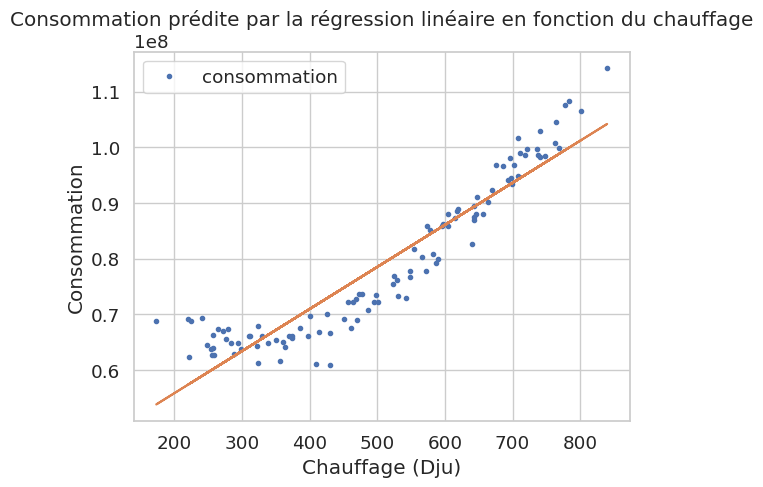

In [24]:
consommations.plot(x='chauffage_dju', y='consommation', style='.')
plt.xlabel('Chauffage (Dju)')
plt.ylabel('Consommation')
plt.title('Consommation pr√©dite par la r√©gression lin√©aire en fonction du chauffage')
plt.plot(consommations['chauffage_dju'], pred_RL.predict(sm.add_constant(consommations['chauffage_dju'])), label=f'Droite de r√©gression (R¬≤ = {pred_RL.rsquared:.2f})')

In [25]:
# Calculer les r√©sidus
regSimp = smf.ols('consommation ~ chauffage_dju', data=consommations).fit()
consommations['consommation_corrigees'] = regSimp.resid
consommations.head(1)

date  consommation  prevision_j1  prevision_j     fioul    charbon  \
0 2012-01-01   101573076.0   201985150.0  201244900.0  893223.0  1537770.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   

   bioenergies               STATIONS  chauffage_dju  consommation_corrigees  
0    1039213.0  75 - PARIS-MONTSOURIS          708.0            7.361998e+06

In [26]:
correlationPearsonRegression = consommations['consommation'].corr(consommations['consommation_corrigees'])
print(f"Coefficient Pearson: {correlationPearson}")

Coefficient Pearson: 0.9349246498346176


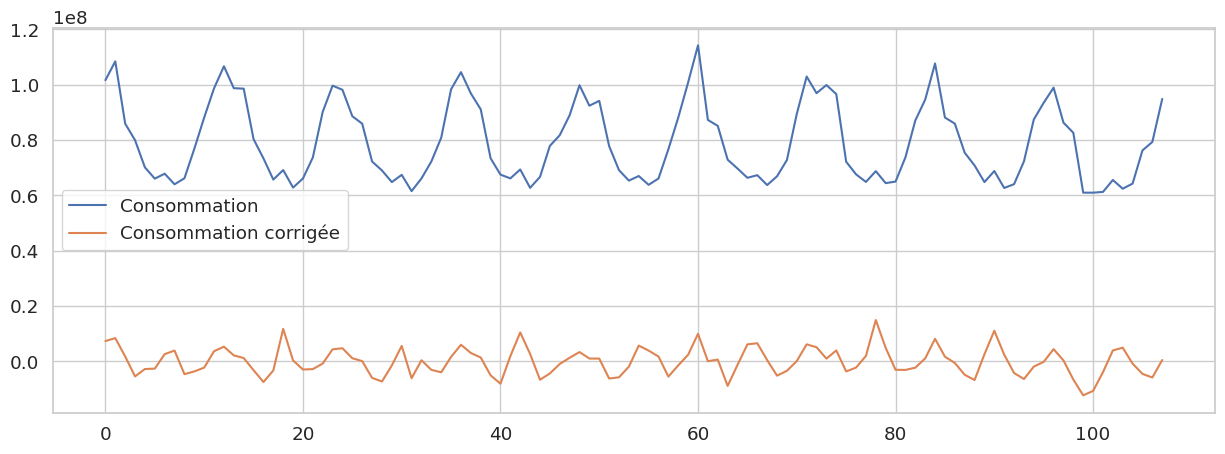

In [27]:
plt.subplots(figsize=(15, 5))
plt.plot(consommations['consommation'], label='Consommation')
plt.plot(consommations['consommation_corrigees'], label='Consommation corrig√©e')
plt.savefig("resources/img/comparaison_chauffage.png")
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


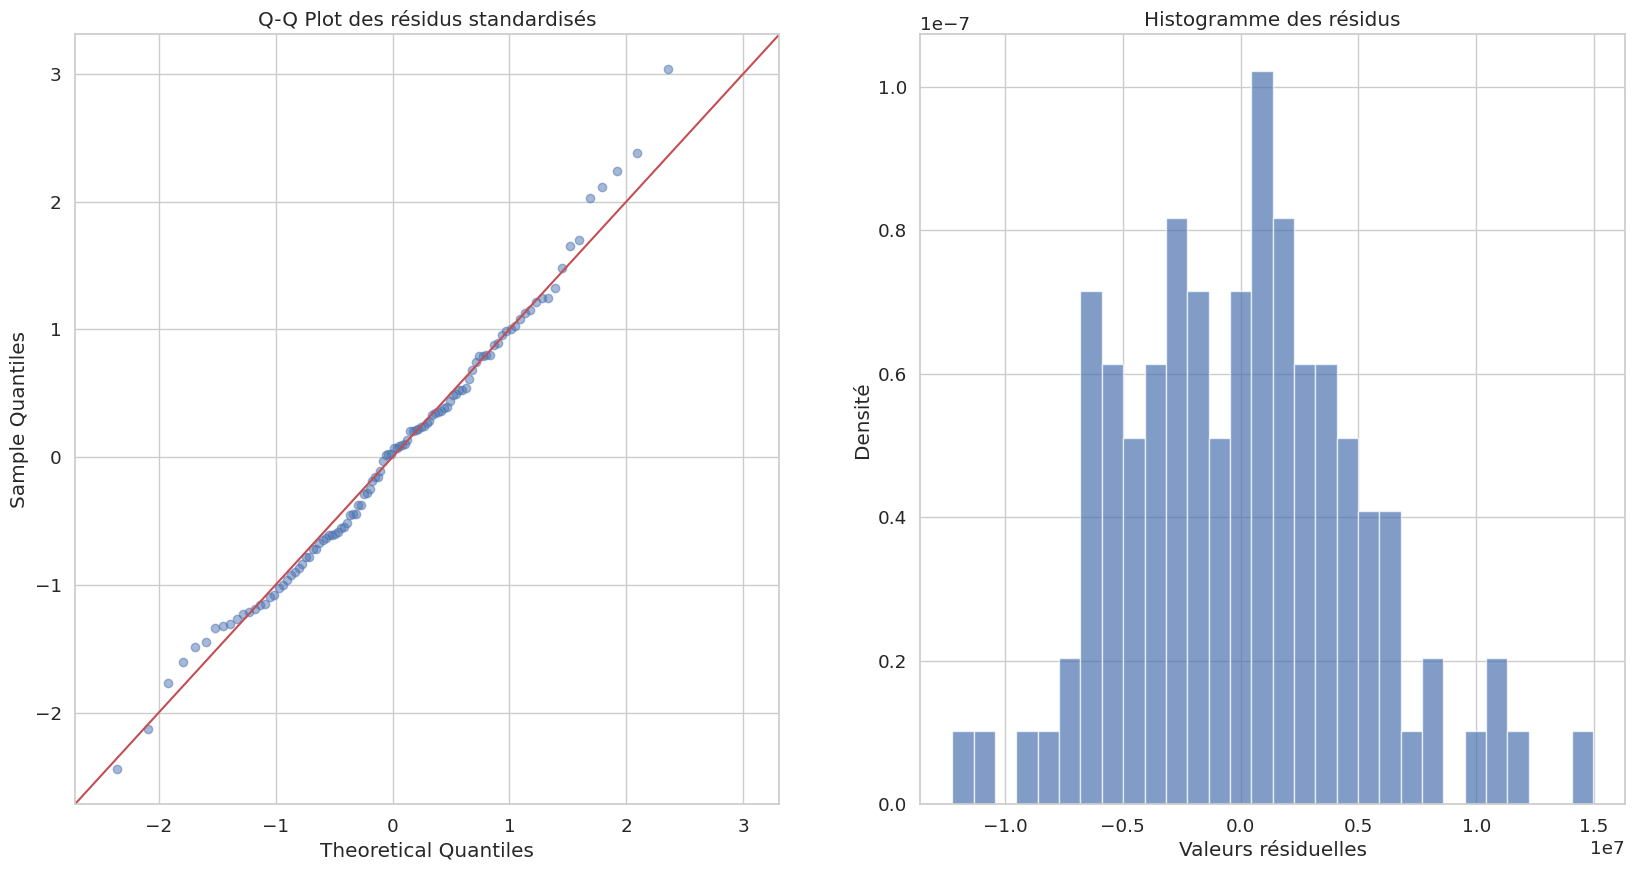

In [28]:
# Cr√©ation des sous-graphiques
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# R√©cup√©ration des r√©sidus
residus = pred_RL.resid

# Histogramme des r√©sidus (axe 1)
ax[1].hist(residus, bins=30, density=True, color='#4C72B0', alpha=0.7)
ax[1].set_title("Histogramme des r√©sidus")
ax[1].set_xlabel("Valeurs r√©siduelles")
ax[1].set_ylabel("Densit√©")

# Q-Q plot (axe 0)
model_norm_residuals = pred_RL.get_influence().resid_studentized_internal
qq = ProbPlot(model_norm_residuals)
qq.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])
ax[0].set_title("Q-Q Plot des r√©sidus standardis√©s")

# Sauvegarde et affichage
plt.savefig('resources/img/residus_reg.png', transparent=True)
plt.show()

#### Le mod√®le est donc acceptable: 
- Q-Q Plot (√† gauche)
- - Les points suivent globalement la ligne rouge
  - Les r√©sidus sontnormalement distribu√©s (avec quelques r√©sidus acceptable)
- Histogramme (√† droite)
- - L‚Äôhistogramme est centr√© autour de 0, ce qui est attendu.
  - La forme est asym√©trique, avec une queue un peu longue √† droite
  - Cela indique qu‚Äôil y a quelques grandes valeurs de r√©sidus positifs : le mod√®le sous-estime parfois beaucoup la consommation r√©elle.
- Les r√©sidus sont assez bien distribu√©s, donc le mod√®le est globalement correct.
- Il y a quelques valeurs extr√™mes ‚Üí peut-√™tre des outliers ou un ph√©nom√®ne non expliqu√© par la variable chauffage_dju.



In [29]:
# Le test de Shapiro-Wilk sert √† v√©rifier si une distribution suit une loi normale. 
# Il est souvent utilis√© pour tester la normalit√© des r√©sidus dans une r√©gression.
#Test de Shapiro-Wilk
stat, p_value = shapiro(pred_RL.resid)
print(f"Statistique de Shapiro-Wilk : {stat}")
print(f"p-value : {p_value}")

Statistique de Shapiro-Wilk : 0.9911911487579346
p-value : 0.714260995388031


- - La p-value est largement sup√©rieure √† 0.05 ‚Üí on ne rejette pas l‚Äôhypoth√®se de normalit√©.
- - Cela signifie que tes r√©sidus suivent une loi normale, ou du moins suffisamment proche pour que le mod√®le soit consid√©r√© comme fiable.

# Effectuez une d√©saisonnalisation de la consommation que vous aurez obtenue apr√®s correction, gr√¢ce aux moyennes mobiles.

### Pourquoi d√©saisonnaliser ?

- Notre objectif est de pr√©dire la consommation future.

- - La saisonnalit√© :
  - Le mod√®le peut √™tre perturb√© : il risque de "confondre" variations normales (hiver, √©t√©) et vraies √©volutions (croissance, d√©croissance de fond).

- - En d√©saisonnalisant :
  - Tu aides ton mod√®le √† mieux comprendre la vraie dynamique de la consommation d'√©lectricit√©, ind√©pendamment des saisons.

- Dans le projet pr√©cis√©ment :
- - On as d√©j√† corrig√© l'effet temp√©rature (important pour enlever le chauffage √©lectrique).
- - Exemple : m√™me si l‚Äôhiver est doux, en janvier, la consommation est toujours un peu plus √©lev√©e que la moyenne ‚Üí la d√©saisonnalisation va corriger √ßa.

In [30]:
consommations.columns

Index(['date', 'consommation', 'prevision_j1', 'prevision_j', 'fioul',
       'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire', 'hydraulique',
       'pompage', 'bioenergies', 'STATIONS', 'chauffage_dju',
       'consommation_corrigees'],
      dtype='object')

In [31]:
consommations['date'] = pd.to_datetime(consommations['date'])

consommations.set_index('date', inplace=True)
decomposeSeason = seasonal_decompose(
    consommations['consommation_corrigees'], 
    model='additive',
    period=12
)
seasonValues = decomposeSeason.seasonal
seasonValues

date
2012-01-01    6.051205e+06
2012-02-01    1.466095e+06
2012-03-01    2.772367e+05
2012-04-01   -6.128378e+06
2012-05-01   -6.042803e+06
                  ...     
2020-08-01    1.441841e+06
2020-09-01   -3.085219e+06
2020-10-01   -3.980945e+06
2020-11-01   -1.551824e+06
2020-12-01    2.721028e+06
Name: seasonal, Length: 108, dtype: float64

In [32]:
consommations['consommation_saison'] = consommations['consommation_corrigees'] - seasonValues
consommations['consommation_corrigees'].isnull().sum()
consommations['consommation_corrigees'] = consommations['consommation_corrigees'].fillna(0) 
consommations.to_csv("resources/data/valid/consommations_corrigee_saison.csv", index=False)
consommations.head(2)

consommation  prevision_j1  prevision_j      fioul    charbon  \
date                                                                        
2012-01-01   101573076.0   201985150.0  201244900.0   893223.0  1537770.0   
2012-02-01   108364070.0   217363100.0  216323300.0  2070743.0  5111869.0   

                  gaz   nucleaire     eolien   solaire  hydraulique  \
date                                                                  
2012-01-01  8150964.0  85553029.0  3170579.0  233044.0   13372457.0   
2012-02-01  9966798.0  77305538.0  2242160.0  404651.0   10405047.0   

              pompage  bioenergies               STATIONS  chauffage_dju  \
date                                                                       
2012-01-01 -1222987.0    1039213.0  75 - PARIS-MONTSOURIS          708.0   
2012-02-01  -835944.0     924169.0  75 - PARIS-MONTSOURIS          783.9   

            consommation_corrigees  consommation_saison  
date                                                     
2012-01-01            7.361998e+06         1.310793e+06  
2012-02-01            8.411706e+06         6.945610e+06

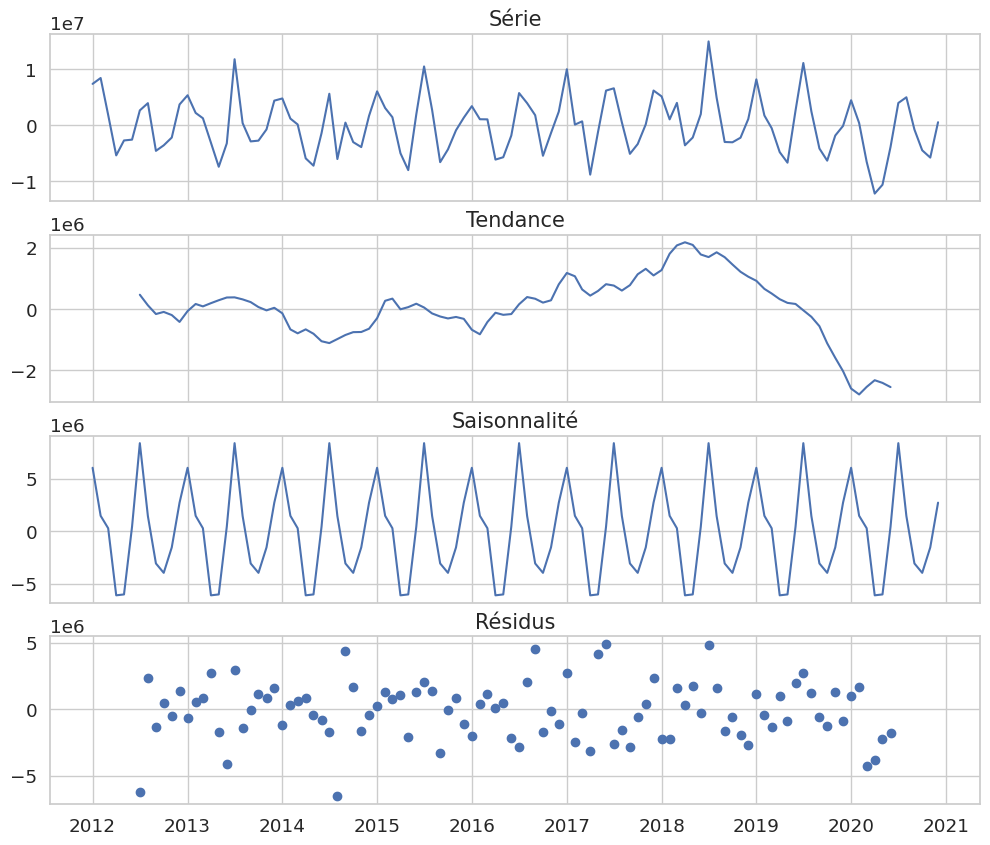

In [33]:
fig, ax = plt.subplots(4, 1, figsize=(12, 10), sharex=True)  # Partage X pour aligner

ax[0].plot(decomposeSeason.observed)
ax[0].set_title('S√©rie', fontsize=15)

ax[1].plot(decomposeSeason.trend)
ax[1].set_title('Tendance', fontsize=15)

ax[2].plot(decomposeSeason.seasonal)
ax[2].set_title('Saisonnalit√©', fontsize=15)

ax[3].plot(decomposeSeason.resid, 'bo')
ax[3].set_title('R√©sidus', fontsize=15)

plt.savefig('resources/img/series_saison.png', transparent=False)


- S√©rie observ√©e : on voit une consommation d'√©nergie marqu√©e par de fortes fluctuations r√©guli√®res (saisonnalit√©) et une certaine variabilit√© globale.

- Tendance : une tendance g√©n√©rale est visible : la consommation augmente l√©g√®rement entre 2016 et 2018 avant de d√©cro√Ætre ensuite. Cela montre une √©volution lente du comportement √©nerg√©tique sur plusieurs ann√©es.

- Saisonnalit√© : une forte p√©riodicit√© annuelle est clairement identifiable, avec des pics r√©currents (en hiver) et des creux (en √©t√©), li√©s aux besoins de chauffage et de climatisation.

- R√©sidus : les r√©sidus semblent r√©partis de mani√®re assez al√©atoire autour de z√©ro, ce qui indique que la majeure partie de l'information de la s√©rie est bien captur√©e par la tendance + la saisonnalit√©.

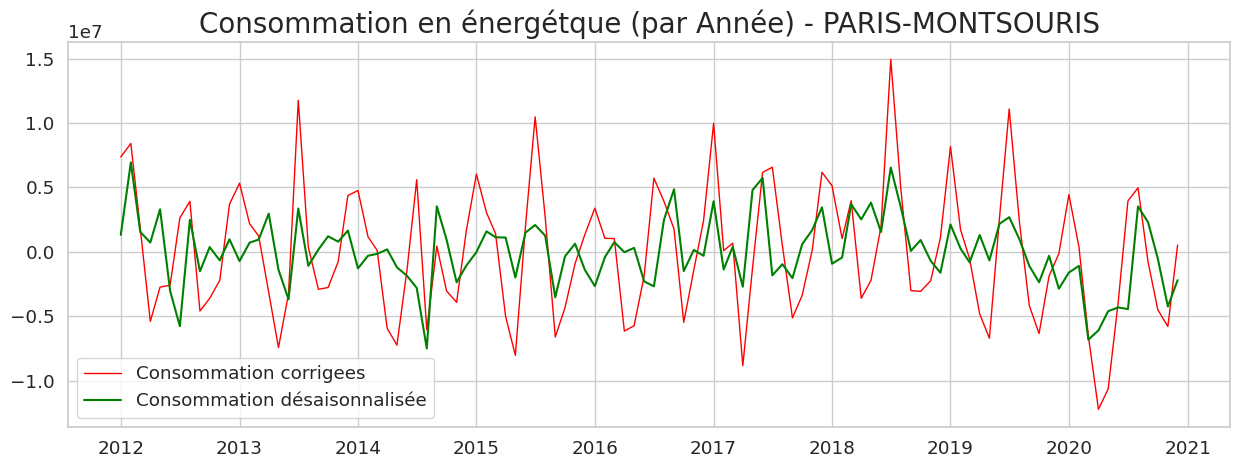

In [34]:
plt.figure(figsize=(15,5))
plt.plot(consommations["consommation_corrigees"], color="red", label="Consommation corrigees", linewidth=1)
plt.plot(consommations["consommation_saison"], color="green", label="Consommation d√©saisonnalis√©e")

plt.title("Consommation en √©nerg√©tque (par Ann√©e) - PARIS-MONTSOURIS", fontsize=20), plt.legend()
plt.savefig("Consommation en √©nerg√©tque (par Ann√©e) - PARIS-MONTSOURIS", transparent=True)
plt.savefig('resources/img/conso_desaisonnalisee.png', transparent=True)
plt.show()

In [35]:
consommations = consommations.reset_index()
consommations['date'] = pd.to_datetime(consommations['date'])
consommations.to_csv("resources/data/valid/correction_consommations.csv", index=False)
consommations.head(1)

date  consommation  prevision_j1  prevision_j     fioul    charbon  \
0 2012-01-01   101573076.0   201985150.0  201244900.0  893223.0  1537770.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   

   bioenergies               STATIONS  chauffage_dju  consommation_corrigees  \
0    1039213.0  75 - PARIS-MONTSOURIS          708.0            7.361998e+06   

   consommation_saison  
0         1.310793e+06

- En rouge, la consommation d'√©nergie corrig√©e de l'effet temp√©rature, mais encore soumise √† des variations saisonni√®res.

- En vert, la consommation d√©saisonnalis√©e, c'est-√†-dire sans les effets r√©guliers des saisons.

Apr√®s d√©saisonnalisation (courbe verte), ces pics disparaissent presque compl√®tement : la s√©rie devient plus stable autour d'une moyenne, et on observe mieux la tendance r√©elle de la consommation d'√©nergie.

# Effectuez une pr√©vision de la consommation (corrig√©e de l'effet temp√©rature) sur un an, en utilisant la m√©thode de Holt Winters (lissage exponentiel) puis la m√©thode SARIMA sur la s√©rie temporelle.


# ExponentialSmoothing

## D√©finition

`ExponentialSmoothing` est une m√©thode de pr√©vision de s√©ries temporelles qui utilise le **lissage exponentiel**.  
Elle accorde **plus de poids aux observations r√©centes** qu'aux plus anciennes, ce qui permet de mieux capturer les √©volutions r√©centes de la s√©rie.

# Le lissage exponentiel, c'est quoi ?

Le lissage exponentiel est une m√©thode pour **pr√©voir des donn√©es dans le temps**.

Le principe est simple :
- **On donne plus d'importance aux donn√©es r√©centes**, 
- **Et un peu moins aux donn√©es plus anciennes**.

C'est comme une moyenne, mais **intelligente** :  
plus une information est r√©cente, plus elle compte dans la pr√©vision.

- Le **coefficient** (entre 0 et 1) d√©cide **combien** on fait confiance √† la nouvelle valeur.
  - Proche de 1 ‚Üí on suit beaucoup la nouvelle valeur.
  - Proche de 0 ‚Üí on suit surtout l'ancienne tendance.

## Pourquoi utiliser le lissage exponentiel ?

 Pour **suivre rapidement** les changements r√©cents,  
 Pour **pr√©voir facilement** sans avoir un mod√®le compliqu√©,  
 Pour **lisser** les petites variations al√©atoires et mieux voir la tendance de fond.


## Exemple concret du lissage exponentiel

Imaginons que vous regardiez la consommation d‚Äô√©lectricit√© chaque mois :
- Si la consommation monte soudainement cet hiver,
- Le lissage exponentiel **s‚Äôadapte rapidement** pour en tenir compte dans vos pr√©visions.


## Pourquoi utiliser  `ExponentialSmoothing`?

- **Saisir la tendance** : mod√©liser une hausse ou une baisse progressive dans la s√©rie.
- **Saisir la saisonnalit√©** : mod√©liser des motifs r√©currents sur une base r√©guli√®re (par exemple, variations saisonni√®res).
- **Am√©liorer les pr√©visions** : en combinant tendance + saisonnalit√©, on obtient des pr√©dictions plus pr√©cises.


## Application dans ce projet
 
Dans le projet de pr√©vision de la demande en √©lectricit√© :
- **La tendance** traduit l'√©volution g√©n√©rale de la consommation sur plusieurs ann√©es.
- **La saisonnalit√©** capture les fluctuations r√©guli√®res (ex : consommation plus forte en hiver).
  
Utiliser `ExponentialSmoothing` permet de **pr√©voir la consommation future** en tenant compte √† la fois :
- Des changements longs termes (tendance)
- Et des motifs saisonniers r√©p√©t√©s chaque ann√©e (saisonnalit√©)

# Comment fonctionne `ExponentialSmoothing` ?

`ExponentialSmoothing` est un mod√®le de s√©ries temporelles bas√© sur le **lissage exponentiel**.  
Il donne **plus d'importance aux donn√©es r√©centes**, tout en tenant compte des anciennes observations.

√Ä chaque nouvelle donn√©e :
- Le mod√®le ajuste une **valeur liss√©e**,
- En utilisant une **formule tr√®s simple** qui combine l'ancienne pr√©vision et la nouvelle observation.

La formule ressemble √† √ßa :

---

## Les trois composants du mod√®le

| √âl√©ment       | R√¥le dans la s√©rie temporelle                    | Exemple r√©el                          |
|:--------------|:--------------------------------------------------|:--------------------------------------|
| Niveau (**Level**)      | Valeur moyenne actuelle de la s√©rie              | Niveau moyen de consommation d'√©lectricit√© |
| Tendance (**Trend**)    | √âvolution progressive (hausse ou baisse)         | Augmentation annuelle de la consommation |
| Saisonnalit√© (**Seasonality**) | Motifs r√©guliers qui se r√©p√®tent dans le temps | Pic de consommation en hiver |

---

## Fonctionnement g√©n√©ral

√Ä chaque nouvelle donn√©e, le mod√®le :
1. Met √† jour le **niveau** (valeur centrale de la s√©rie),
2. Met √† jour la **tendance** (direction de la s√©rie),
3. Met √† jour la **saisonnalit√©** (comportement p√©riodique).

Ces mises √† jour utilisent des **coefficients de lissage** :
- **Alpha (Œ±)** : pour ajuster le niveau,
- **Beta (Œ≤)** : pour ajuster la tendance,
- **Gamma (Œ≥)** : pour ajuster la saisonnalit√©.

> Plus le coefficient est proche de 1, plus le mod√®le est **r√©actif** aux nouvelles donn√©es.



# Holt Winters

In [36]:
dataHoltWinters = pd.read_csv("resources/data/valid/correction_consommations.csv", parse_dates=True)
dataHoltWinters["date"] = pd.to_datetime(dataHoltWinters["date"])
dataHoltWinters.head(1)

date  consommation  prevision_j1  prevision_j     fioul    charbon  \
0 2012-01-01   101573076.0   201985150.0  201244900.0  893223.0  1537770.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   

   bioenergies               STATIONS  chauffage_dju  consommation_corrigees  \
0    1039213.0  75 - PARIS-MONTSOURIS          708.0            7.361998e+06   

   consommation_saison  
0         1.310793e+06

In [37]:
def mapeWinters(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # √âviter la division par z√©ro
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        raise ValueError("Toutes les valeurs de y_true sont nulles, MAPE impossible √† calculer.")
    
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]
    
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [38]:
def holt_winters_forecast_plot(df, forecast_periods=12, suffix="default", mode="forecast", y_true=None, comparaison_dfs=None):
    warnings.filterwarnings("ignore")

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    y = np.asarray(df["consommation_corrigees"])

    model = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
    forecast = model.forecast(forecast_periods)
    fitted = model.fittedvalues

    last_date = df["date"].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_periods, freq='M')

    # ‚û§ MODE = forecast
    if mode == "forecast":
        fig, ax = plt.subplots(figsize=(15, 5))
        
        ax.plot(df["date"], df["consommation_corrigees"], label="Consommation r√©elle")
        ax.plot(future_dates, forecast, label="Pr√©vision Holt-Winters", color="orange")
        ax.set_title(f"Pr√©vision consommation ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrig√©e")
        ax.legend()
        ax.grid(True)
        
        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/prevision_consommation_{suffix}.png", transparent=True)
        plt.show()

        if len(y) >= forecast_periods:
            mape_val = mapeWinters(y[-forecast_periods:], forecast)
            print(f"MAPE : {mape_val:.2f}%")

    # ‚û§ MODE = verify
    elif mode == "verify":
        if y_true is None:
            raise ValueError("y_true est requis en mode 'verify'.")

        y_true = np.asarray(y_true)
        if len(y_true) != forecast_periods:
            raise ValueError("y_true doit avoir la m√™me longueur que forecast_periods")

        fig, ax = plt.subplots(figsize=(15, 5))

        # ‚û§ Consommation r√©elle historique
        ax.plot(df["date"], df["consommation_corrigees"], label="Historique", color='blue')

        # ‚û§ Valeurs r√©elles sur la p√©riode de pr√©vision
        #ax.plot(future_dates, y_true, label="Valeurs r√©elles (ann√©e N)", color='blue')

        # ‚û§ Pr√©visions Holt-Winters actuelles
        #ax.plot(future_dates, forecast, label="Pr√©vision Holt-Winters (ann√©e N)", color='orange', linestyle='--')

        # ‚û§ Pr√©vision ann√©e N-1
        if len(df) >= 12 + forecast_periods:
            df_n1 = df.iloc[:-12]
            y_n1 = np.asarray(df_n1["consommation_corrigees"])
            model_n1 = ExponentialSmoothing(y_n1, seasonal_periods=12, trend='add', seasonal='add').fit()
            forecast_n1 = model_n1.forecast(forecast_periods)
            future_dates_n1 = pd.date_range(start=df_n1["date"].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_n1, forecast_n1, label="Pr√©vision ann√©e N-1", linestyle=':', color='green')

        # ‚û§ Pr√©vision ann√©e N-2
        if len(df) >= 24 + forecast_periods:
            df_n2 = df.iloc[:-24]
            y_n2 = np.asarray(df_n2["consommation_corrigees"])
            model_n2 = ExponentialSmoothing(y_n2, seasonal_periods=12, trend='add', seasonal='add').fit()
            forecast_n2 = model_n2.forecast(forecast_periods)
            future_dates_n2 = pd.date_range(start=df_n2["date"].iloc[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_n2, forecast_n2, label="Pr√©vision ann√©e N-2", linestyle='--', color='purple')

        ax.set_title(f"V√©rification des pr√©visions ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrig√©e")
        ax.legend()
        ax.grid(True)

        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/verification_consommation_{suffix}.png", transparent=True)
        plt.show()

        mapeVal = mapeWinters(y_true, forecast)
        print(f"MAPE (Erreur moyenne absolue en pourcentage) : {mapeVal:.2f}%")

    # ‚û§ Comparaison facultative
    if comparaison_dfs and mode == "forecast":
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.plot(df["date"], df["consommation_corrigees"], label="Consommation r√©elle", color='blue')

        for comp_label, comp_df in comparaison_dfs:
            comp_df = comp_df.copy()
            comp_df["date"] = pd.to_datetime(comp_df["date"])
            y_comp = np.asarray(comp_df["consommation_corrigees"])
            model_comp = ExponentialSmoothing(y_comp, seasonal_periods=12, trend='add', seasonal='add').fit()
            pred_comp = model_comp.forecast(forecast_periods)
            last_date_comp = comp_df["date"].iloc[-1]
            future_dates_comp = pd.date_range(start=last_date_comp + pd.DateOffset(months=1), periods=forecast_periods, freq='M')
            ax.plot(future_dates_comp, pred_comp, label=f"Pr√©vision {comp_label}", linestyle='--')

        ax.set_title(f"Comparaison des pr√©visions ({suffix})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Consommation corrig√©e")
        ax.legend()
        ax.grid(True)
        for label in ax.get_xticklabels():
            label.set_fontstyle('italic')

        plt.savefig(f"resources/img/prevision_comparee_{suffix}.png", transparent=True)
        plt.show()

    return forecast, future_dates


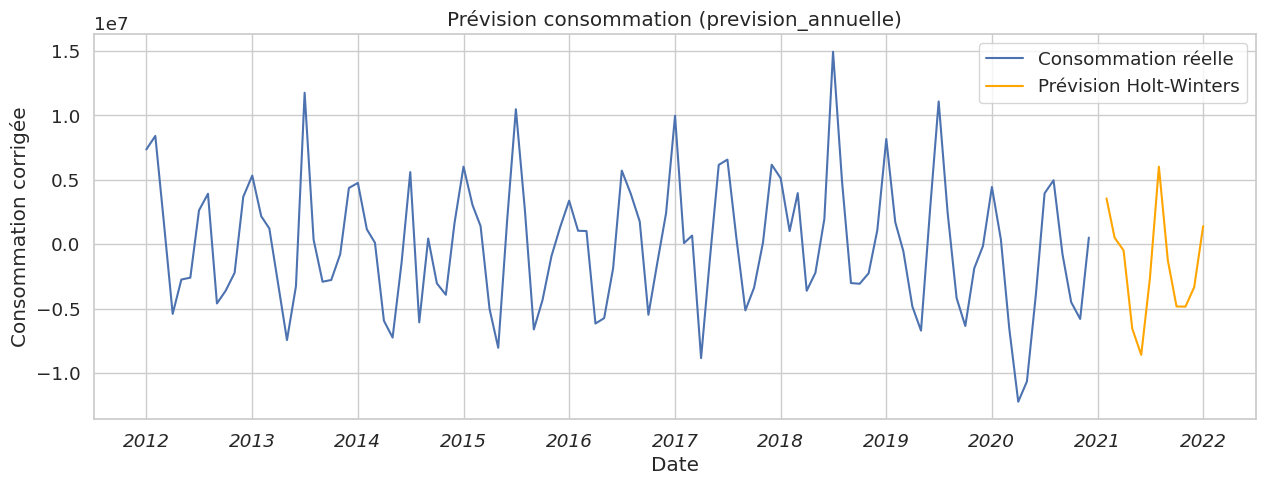

MAPE : 0.97%


(array([ 3564041.95073871,   507780.20149789,  -482817.394446  ,
        -6553031.90508728, -8591295.04360526, -2640987.0000771 ,
         6019969.59755168, -1260952.19563776, -4831392.42949101,
        -4844344.91007915, -3330482.39161481,  1404763.48434482]),
 DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
                '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
                '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
               dtype='datetime64[ns]', freq='ME'))

In [39]:
holt_winters_forecast_plot(
    df=dataHoltWinters,
    forecast_periods=12,
    suffix="prevision_annuelle",
    mode="forecast"
)

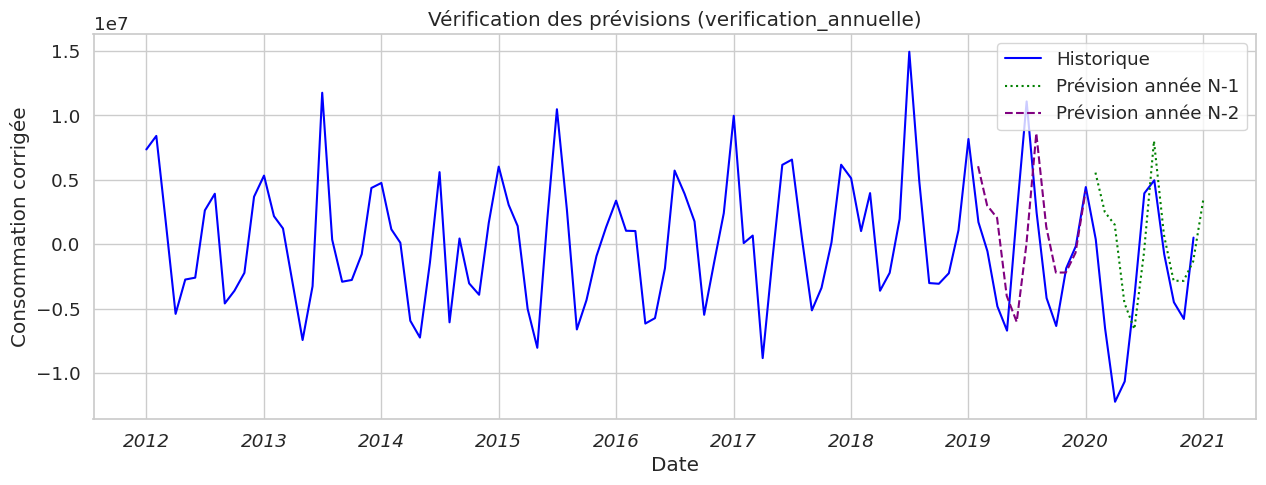

MAPE (Erreur moyenne absolue en pourcentage) : 0.97%


(array([ 3564041.95073871,   507780.20149789,  -482817.394446  ,
        -6553031.90508728, -8591295.04360526, -2640987.0000771 ,
         6019969.59755168, -1260952.19563776, -4831392.42949101,
        -4844344.91007915, -3330482.39161481,  1404763.48434482]),
 DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
                '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
                '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
               dtype='datetime64[ns]', freq='ME'))

In [40]:
forecast_periods = 12
dataHoltWinters = dataHoltWinters.sort_values("date")
dataHoltWinters["date"] = pd.to_datetime(dataHoltWinters["date"])

# 3. S√©parer les donn√©es en historique + r√©el
historical_df = dataHoltWinters.iloc[:-forecast_periods].copy()
y_truth = dataHoltWinters.iloc[-forecast_periods:]["consommation_corrigees"].values

holt_winters_forecast_plot(
    df=dataHoltWinters,
    forecast_periods=12,
    suffix="verification_annuelle",
    mode="verify",
    y_true=y_truth
)

# M√©thode SARIMA

## D√©finition

SARIMA (Seasonal AutoRegressive Integrated Moving Average) est un mod√®le de pr√©vision qui permet de pr√©dire l‚Äôavenir √† partir des donn√©es pass√©es en tenant compte des saisons (mois, semaines, etc.).

# üìà Comprendre ADF, ACF et PACF pour la Pr√©diction de la Consommation avec SARIMA

Dans un projet de **pr√©diction de la consommation** (ex. √©l√©ctricit√©, √©nergie, eau, gaz), il est essentiel de comprendre la structure de la s√©rie temporelle avant de mod√©liser. Les outils cl√©s sont :

- Le **test de Dickey-Fuller Augment√© (ADF)**,
- Les **autocorr√©lations (ACF)**,
- Les **autocorr√©lations partielles (PACF)**.

Ils permettent de v√©rifier si les **conditions n√©cessaires √† l‚Äôutilisation du mod√®le SARIMA** sont remplies.

---

## ‚úÖ 1. Test de Dickey-Fuller Augment√© (ADF)

### üîé D√©finition simple
Le test ADF permet de v√©rifier si une s√©rie temporelle est **stationnaire**, c‚Äôest-√†-dire si sa **moyenne** et sa **variance** restent **stables dans le temps**.

> _Une s√©rie stationnaire_ est une s√©rie temporelle dont les propri√©t√©s statistiques ne varient pas avec le temps. Elle n‚Äôa ni tendance (_trend_) ni saisonnalit√© persistante.

### üîé Interpr√©tation du test

Le test renvoie une **statistique ADF** ainsi qu‚Äôune **p-value**. C‚Äôest cette p-value qui permet de conclure sur la stationnarit√©.

| p-value         | Conclusion                           |
|-----------------|---------------------------------------|
| **< 0.05**      | ‚úÖ La s√©rie est **stationnaire**       |
| **‚â• 0.05**      | ‚ùå La s√©rie est **non stationnaire**   |

---

### üß† Pourquoi c‚Äôest important ?
Le mod√®le **SARIMA** (Saisonnal ARIMA) suppose que la s√©rie est stationnaire.  
Si la s√©rie n'est **pas stationnaire**, on ne peut pas l‚Äôutiliser directement dans SARIMA : il faut la transformer via des **diff√©renciations (param√®tres `d` et `D`)**.

### üìå Interpr√©tation
- **H‚ÇÄ (hypoth√®se nulle)** : la s√©rie **n‚Äôest pas stationnaire**.
- Si **p-value < 0.05** ‚Üí ‚ùó on rejette H‚ÇÄ ‚Üí la s√©rie est **stationnaire ‚úÖ**.
- Sinon ‚Üí ‚ùå la s√©rie est **non stationnaire**, on applique `.diff()` ou une diff√©renciation saisonni√®re.

---

## üîÑ 2. ACF ‚Äî Autocorrelation Function

### üîé D√©finition simple
L‚Äô**ACF** mesure l‚Äôinfluence des valeurs pass√©es sur la valeur actuelle pour diff√©rents **d√©calages (lags)**.

Concr√®tement, elle indique **dans quelle mesure la consommation d‚Äôaujourd‚Äôhui d√©pend de celle des jours pr√©c√©dents**.

Pour chaque **d√©calage temporel** (ou **lag**), on calcule la **force de cette d√©pendance** :

- **lag = 1** ‚Üí compare aujourd‚Äôhui avec **hier**  
- **lag = 7** ‚Üí compare aujourd‚Äôhui avec **la semaine derni√®re**
- **lag = 30** ‚Üí compare aujourd‚Äôhui avec **le m√™me jour du mois dernier**


### üß† Pourquoi c‚Äôest important ?
L‚ÄôACF permet :
- d‚Äôobserver des **saisonnalit√©s** (pics r√©guliers),
- de d√©terminer si une **diff√©renciation est n√©cessaire** (si la d√©croissance est lente),
- de choisir l‚Äôordre du **terme MA (Moving Average)** dans SARIMA.

### üìå Exemple
- Si l‚ÄôACF **d√©cro√Æt lentement** ‚Üí tendance non stationnaire ‚Üí il faut **diff√©rencier**.
- Si l‚ÄôACF **chute vite** ‚Üí s√©rie probablement stationnaire.

---

## üîÅ 3. PACF ‚Äî Partial Autocorrelation Function

### üîé D√©finition simple
La **PACF** mesure la **corr√©lation directe** entre une observation et une observation pr√©c√©dente (ex : `t` et `t-1`), en **√©liminant l'effet des autres lags** interm√©diaires.

> Autrement dit : PACF montre **le lien direct entre la consommation d‚Äôaujourd‚Äôhui et celle de n jours avant**, **en ignorant ce qui s‚Äôest pass√© entre-temps**.

### üß† Pourquoi c‚Äôest important ?
La PACF permet de :
- d√©terminer le nombre de **termes AR (Auto-R√©gressifs)** √† inclure dans le mod√®le SARIMA,
- identifier les **d√©pendances directes** sur les valeurs pass√©es.

### üìå Exemple
- Si la PACF est significative jusqu‚Äôau lag 2 ‚Üí on peut tester un mod√®le avec **AR(2)**.

---

> ‚úÖ **Conclusion :** Avant d‚Äôutiliser un mod√®le SARIMA pour pr√©dire la consommation, il est indispensable de v√©rifier la stationnarit√© (ADF), puis d‚Äôanalyser les d√©pendances temporelles (ACF et PACF) pour choisir les bons param√®tres.


In [41]:
dataSarima = pd.read_csv("resources/data/valid/correction_consommations.csv", parse_dates=True)
dataSarima.head(1)

date  consommation  prevision_j1  prevision_j     fioul    charbon  \
0  2012-01-01   101573076.0   201985150.0  201244900.0  893223.0  1537770.0   

         gaz   nucleaire     eolien   solaire  hydraulique    pompage  \
0  8150964.0  85553029.0  3170579.0  233044.0   13372457.0 -1222987.0   

   bioenergies               STATIONS  chauffage_dju  consommation_corrigees  \
0    1039213.0  75 - PARIS-MONTSOURIS          708.0            7.361998e+06   

   consommation_saison  
0         1.310793e+06

In [42]:
def test_stationarity_with_adf(series, lags=30, title=''):
    """
    Effectue le test de Dickey-Fuller augment√© (ADF) et affiche les ACF/PACF.
    
    Si la s√©rie est stationnaire, enregistre les graphiques dans des fichiers PNG.

    Arguments :
    - series : pd.Series
    - lags : int
    - title : str
    """

    # Nettoyage de la s√©rie
    series_clean = series.dropna()

    # Forcer l'index en datetime si n√©cessaire
    if not np.issubdtype(series_clean.index.dtype, np.datetime64):
        try:
            series_clean.index = pd.to_datetime(series_clean.index)
        except Exception as e:
            print("Erreur : impossible de convertir l'index en datetime :", e)

    n_obs = len(series_clean)
    max_lags = min(lags, n_obs // 2 - 1)

    # === Plot de la s√©rie temporelle ===
    plt.figure(figsize=(10, 4))
    plt.plot(series_clean, label='S√©rie temporelle')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gcf().autofmt_xdate()

    plt.title(f'S√©rie temporelle - {title}')
    plt.xlabel('Temps')
    plt.ylabel('Valeur')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Test ADF ===
    print("=== Test de Dickey-Fuller augment√© ===")
    result = adfuller(series_clean, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# lags used', '# observations']
    for value, label in zip(result[:4], labels):
        print(f"{label} : {value}")

    print("Valeurs critiques :")
    for key, val in result[4].items():
        print(f"   {key} : {val}")

    is_stationary = result[1] <= 0.05
    if is_stationary:
        print("\n‚úÖ La s√©rie est stationnaire (on rejette l'hypoth√®se nulle H0)")
    else:
        print("\n‚ùå La s√©rie n'est PAS stationnaire (on ne rejette pas H0)")

    # === ACF & PACF ===
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(series_clean, ax=axes[0], lags=max_lags)
    axes[0].set_title("ACF - Corr√©lation automatique")

    plot_pacf(series_clean, ax=axes[1], lags=max_lags, method='ywm')
    axes[1].set_title("PACF - Corr√©lation partielle")

    plt.tight_layout()
    plt.show()

    # === Enregistrement si stationnaire ===
    if is_stationary:
        folder = "resources/img"
        os.makedirs(folder, exist_ok=True)

        # Replot & save s√©rie temporelle
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(series_clean, label='S√©rie temporelle')
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        fig.autofmt_xdate()
        ax.set_title(f'S√©rie temporelle - {title}')
        ax.set_xlabel('Temps')
        ax.set_ylabel('Valeur')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        fig.savefig(f"{folder}/{title}_serie_temporelle.png")
        plt.close(fig)

        # Replot & save ACF & PACF
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))
        plot_acf(series_clean, ax=axes[0], lags=max_lags)
        axes[0].set_title("ACF - Corr√©lation automatique")

        plot_pacf(series_clean, ax=axes[1], lags=max_lags, method='ywm')
        axes[1].set_title("PACF - Corr√©lation partielle")

        plt.tight_layout()
        fig.savefig(f"{folder}/{title}_acf_pacf.png")
        plt.close(fig)

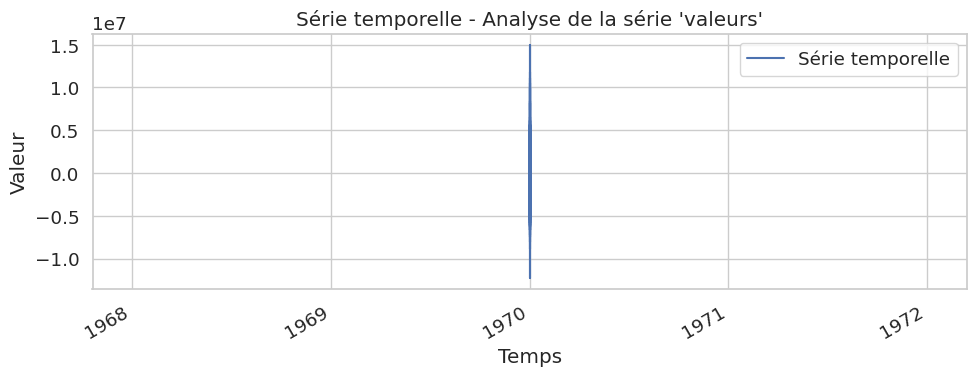

=== Test de Dickey-Fuller augment√© ===
ADF Statistic : -1.782519088863956
p-value : 0.3891743640002461
# lags used : 11
# observations : 96
Valeurs critiques :
   1% : -3.5003788874873405
   5% : -2.8921519665075235
   10% : -2.5830997960069446

‚ùå La s√©rie n'est PAS stationnaire (on ne rejette pas H0)


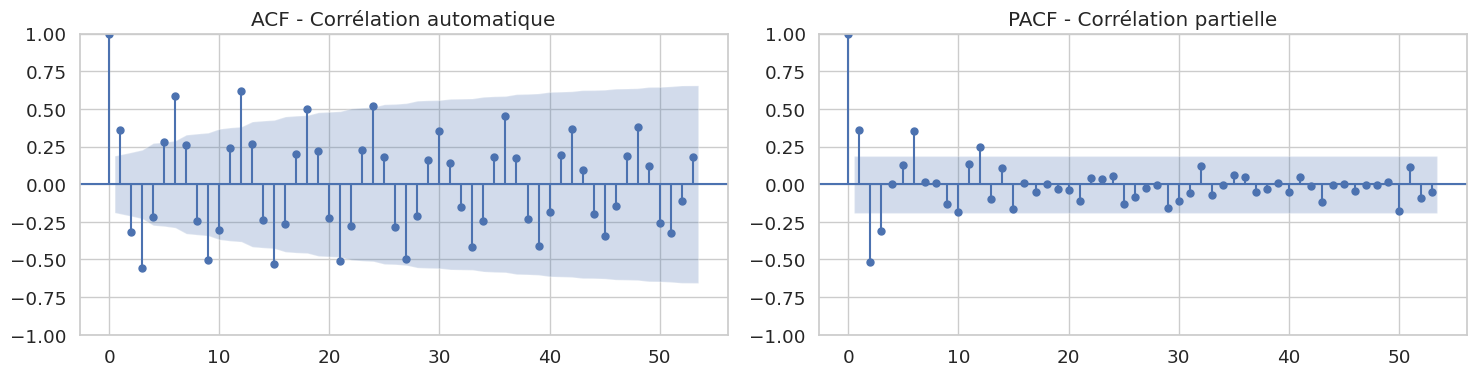

In [43]:
# Test de Dickey‚ÄìFuller avec ACF et PACF
test_stationarity_with_adf(dataSarima['consommation_corrigees'], lags=60, title="Analyse de la s√©rie 'valeurs'")

In [44]:
cpDfSarima = dataSarima.copy()
cpDfSarima.set_index('date', inplace=True)

numerical_cols = cpDfSarima.select_dtypes(include='number').columns
sarimaLessSixMonth = cpDfSarima[numerical_cols] - cpDfSarima[numerical_cols].shift(6)
sarimaLessSixMonth = sarimaLessSixMonth.dropna()

# La colonne date est maintenant dans l'index
print(sarimaLessSixMonth.index)
print(sarimaLessSixMonth['consommation_corrigees'])

Index(['2012-07-01', '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
       '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
       ...
       '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
      dtype='object', name='date', length=102)
date
2012-07-01   -4.732721e+06
2012-08-01   -4.490706e+06
2012-09-01   -6.421611e+06
2012-10-01    1.795548e+06
2012-11-01    5.194071e+05
                  ...     
2020-08-01    4.595758e+06
2020-09-01    5.756610e+06
2020-10-01    7.728060e+06
2020-11-01    4.851089e+06
2020-12-01    4.405273e+06
Name: consommation_corrigees, Length: 102, dtype: float64


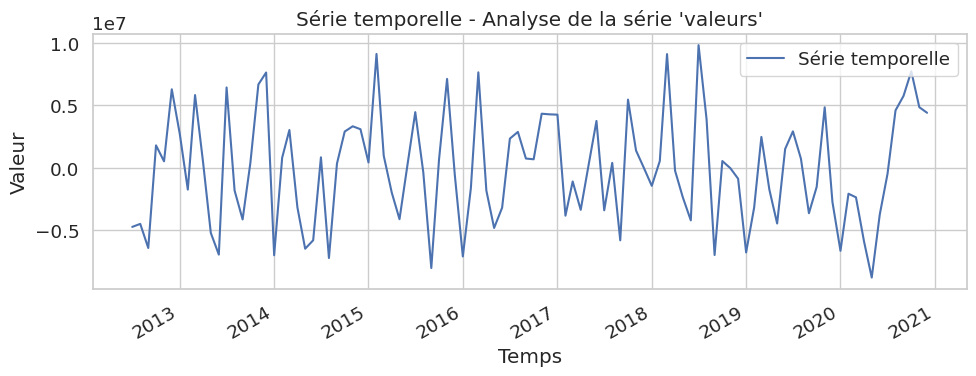

=== Test de Dickey-Fuller augment√© ===
ADF Statistic : -5.8272401371804365
p-value : 4.0523661196268824e-07
# lags used : 7
# observations : 94
Valeurs critiques :
   1% : -3.5019123847798657
   5% : -2.892815255482889
   10% : -2.583453861475781

‚úÖ La s√©rie est stationnaire (on rejette l'hypoth√®se nulle H0)


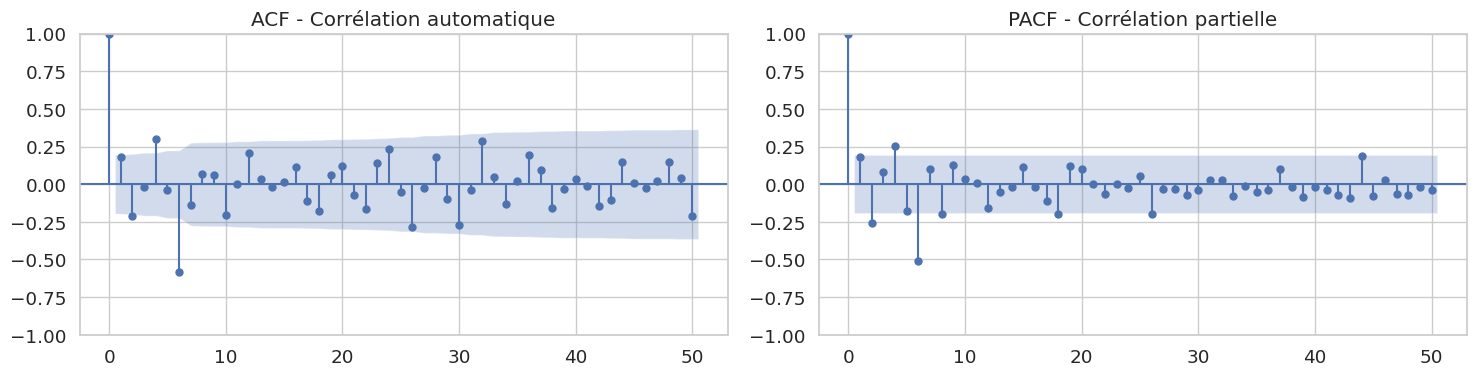

In [45]:
test_stationarity_with_adf(sarimaLessSixMonth['consommation_corrigees'], lags=60, title="Analyse de la s√©rie 'valeurs'")

## Interpr√©tation du graphique ACF / PACF

### ACF ‚Äì Corr√©lation automatique
- Le premier pic (d√©calage 0) est √† 1, ce qui est normal.
- Les corr√©lations chutent rapidement et la majorit√© des valeurs sont dans la zone de confiance.
- Cela indique une absence de corr√©lations significatives √† long terme.

### PACF ‚Äì Corr√©lation partielle
- Un pic significatif est visible √† lag 1, puis les valeurs deviennent n√©gligeables.
- Cela sugg√®re une d√©pendance √† court terme, typique d‚Äôun mod√®le AR(1).

---

## Rappel : qu‚Äôest-ce qu‚Äôune s√©rie stationnaire ?

Une s√©rie temporelle est dite stationnaire lorsque ses propri√©t√©s statistiques (moyenne, variance, autocorr√©lation) restent constantes dans le temps.

### Pourquoi c‚Äôest important ?
- Les mod√®les de pr√©vision comme ARIMA supposent que les s√©ries sont stationnaires.
- Une s√©rie stationnaire est plus facile √† mod√©liser et √† interpr√©ter.
- Elle √©vite les biais dus aux tendances ou aux effets saisonniers.

---

## Conclusion

- Le test ADF indique que la s√©rie est stationnaire.
- Les graphiques ACF et PACF confirment cette stationnarit√©.
- La structure de la PACF sugg√®re un mod√®le auto-r√©gressif simple.


In [46]:
stationaryData = sarimaLessSixMonth.copy().reset_index()
stationaryData.head(1)

date  consommation  prevision_j1  prevision_j     fioul   charbon  \
0  2012-07-01   -33779543.0   -66845650.0  -65987050.0 -406338.0  682181.0   

         gaz   nucleaire     eolien   solaire  hydraulique   pompage  \
0 -6627338.0 -27974874.0 -1350291.0  776905.0   -3584838.0  193705.0   

   bioenergies  chauffage_dju  consommation_corrigees  consommation_saison  
0      -6831.0         -384.0           -4.732721e+06        -7.084751e+06

In [47]:
cpDfSarima2 = dataSarima.copy()
sarimaLessTwelvweMonths = cpDfSarima2['consommation_corrigees'] - cpDfSarima2['consommation_corrigees'].shift(12)
sarimaLessTwelvweMonths = sarimaLessTwelvweMonths.dropna()
sarimaLessTwelvweMonths

12    -2.031648e+06
13    -6.234706e+06
14    -5.986332e+05
15     2.244904e+06
16    -4.696811e+06
           ...     
103    2.519715e+06
104    3.391023e+06
105    1.845348e+06
106   -3.936011e+06
107    6.598187e+05
Name: consommation_corrigees, Length: 96, dtype: float64

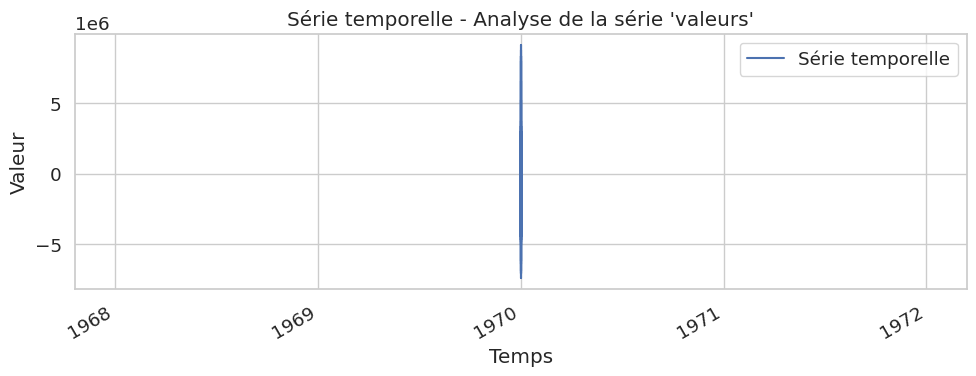

=== Test de Dickey-Fuller augment√© ===
ADF Statistic : -2.480574576523998
p-value : 0.1202725620642715
# lags used : 12
# observations : 83
Valeurs critiques :
   1% : -3.5117123057187376
   5% : -2.8970475206326833
   10% : -2.5857126912469153

‚ùå La s√©rie n'est PAS stationnaire (on ne rejette pas H0)


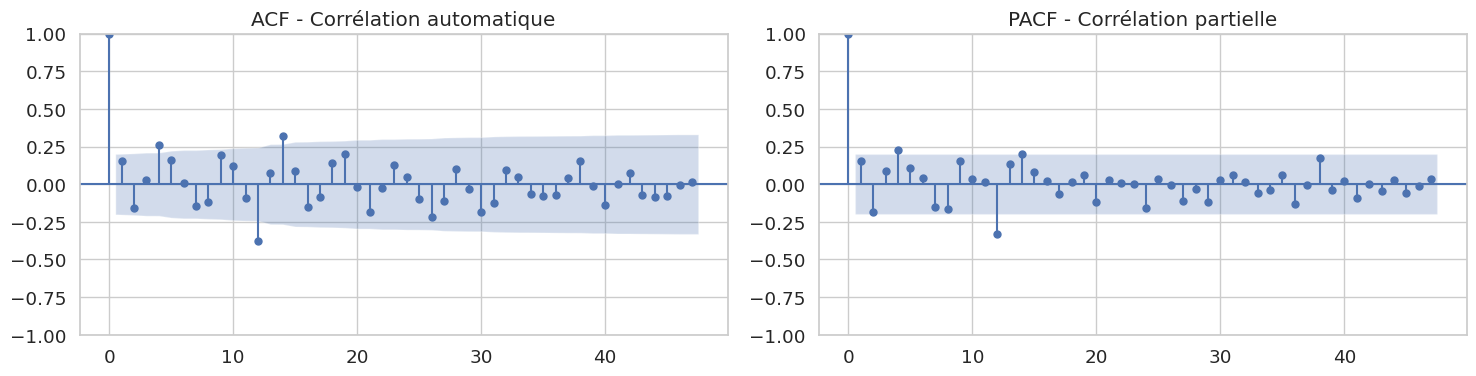

In [48]:
test_stationarity_with_adf(sarimaLessTwelvweMonths, lags=60, title="Analyse de la s√©rie 'valeurs'")

In [49]:
def sarima_predictions(data, predictionLabel=None, titlePlot=None, minYear=None, maxYear=None, seperateLines=False, savePath=None):
    warnings.filterwarnings("ignore")
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    y = data['consommation_corrigees']

    plt.figure(figsize=(14, 6))
    plt.plot(y.index, y, label='Consommation r√©elle', color='blue')

    totalMape = []
    shouldSave = False 
    colorMap = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    if isinstance(minYear, (int, str)):
        minYear = pd.to_datetime(f"{int(minYear)}-01-01")
    if isinstance(maxYear, (int, str)):
        maxYear = pd.to_datetime(f"{int(maxYear)}-12-31")

    if minYear and maxYear and seperateLines:
        years = range(minYear.year, maxYear.year + 1)
        for i, year in enumerate(years):
            delta = maxYear.year - year
            currentStart = pd.to_datetime(f"{year}-01-01")
            currentEnd = maxYear
            label = f"Pr√©vision ann√©e N-1" if delta == 0 else f"Pr√©vision ann√©e N-2"

            train = y[y.index < currentStart]
            test = y[(y.index >= currentStart) & (y.index <= currentEnd)]

            nMonths = (currentEnd.year - year) * 12 + (currentEnd.month - 1) + 1
            testIndex = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=nMonths, freq='MS')

            if len(train) < 24:
                print(f"Pas assez de donn√©es pour entra√Æner le mod√®le avant {year}.")
                continue

            adfResult = adfuller(train)
            forceD = 1 if adfResult[1] > 0.05 else 0
            if forceD == 0:
                shouldSave = True

            autoModel = auto_arima(train,
                                   seasonal=True,
                                   m=12,
                                   d=forceD,
                                   D=1,
                                   max_p=2, max_q=2,
                                   max_P=1, max_Q=1,
                                   start_p=0, start_q=0,
                                   start_P=0, start_Q=0,
                                   trace=False,
                                   error_action='ignore',
                                   suppress_warnings=True,
                                   stepwise=True)

            model = SARIMAX(train,
                            order=autoModel.order,
                            seasonal_order=autoModel.seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()

            forecast = model.forecast(steps=nMonths)
            forecast.index = testIndex

            color = colorMap[i % len(colorMap)]
            plt.plot(forecast, label=label, linestyle='--', color=color)

            commonIndex = test.index.intersection(forecast.index)
            if not commonIndex.empty:
                mape = mean_absolute_percentage_error(test.loc[commonIndex], forecast.loc[commonIndex])
                deltaAbs = (test.loc[commonIndex] - forecast.loc[commonIndex]).abs().mean()
                totalMape.append((label, mape))

                # Fill between actual and forecast
                plt.fill_between(forecast.index,
                                 forecast.values,
                                 test.loc[commonIndex],
                                 color=color,
                                 alpha=0.2)

                print(f"Pr√©cision de {label} : {100 - mape:.2f}% (MAPE = {mape:.2f}%)")
                print(f"√âcart moyen absolu pour {label} : {deltaAbs:.2f}\n")

    elif minYear and maxYear:
        label = f"Pr√©vision personnalis√©e ({minYear.date()} √† {maxYear.date()})"
        train = y[y.index < minYear]
        test = y[(y.index >= minYear) & (y.index <= maxYear)]
        nMonths = (maxYear.year - minYear.year) * 12 + (maxYear.month - minYear.month + 1)
        testIndex = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=nMonths, freq='MS')

        adfResult = adfuller(train)
        forceD = 1 if adfResult[1] > 0.05 else 0
        if forceD == 0:
            shouldSave = True

        autoModel = auto_arima(train,
                               seasonal=True,
                               m=12,
                               d=forceD,
                               D=1,
                               max_p=2, max_q=2,
                               max_P=1, max_Q=1,
                               start_p=0, start_q=0,
                               start_P=0, start_Q=0,
                               trace=False,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

        model = SARIMAX(train,
                        order=autoModel.order,
                        seasonal_order=autoModel.seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

        forecast = model.forecast(steps=nMonths)
        forecast.index = testIndex

        plt.plot(forecast, label=label, linestyle='--', color='green')

        commonIndex = test.index.intersection(forecast.index)
        if not commonIndex.empty:
            mape = mean_absolute_percentage_error(test.loc[commonIndex], forecast.loc[commonIndex])
            deltaAbs = (test.loc[commonIndex] - forecast.loc[commonIndex]).abs().mean()
            totalMape.append((label, mape))

            plt.fill_between(forecast.index,
                             forecast.values,
                             test.loc[commonIndex],
                             color='green',
                             alpha=0.2)

            print(f"‚è±Ô∏è Pr√©cision de {label} : {100 - mape:.2f}% (MAPE = {mape:.2f}%)")
            print(f"üîé √âcart moyen absolu pour {label} : {deltaAbs:.2f}\n")

    else:
        label = "Pr√©vision 12 mois futurs"
        train = y
        nMonths = 12
        testIndex = pd.date_range(start=train.index[-1] + pd.DateOffset(months=1), periods=nMonths, freq='MS')

        adfResult = adfuller(train)
        forceD = 1 if adfResult[1] > 0.05 else 0
        if forceD == 0:
            shouldSave = True

        autoModel = auto_arima(train,
                               seasonal=True,
                               m=12,
                               d=forceD,
                               D=1,
                               max_p=2, max_q=2,
                               max_P=1, max_Q=1,
                               start_p=0, start_q=0,
                               start_P=0, start_Q=0,
                               trace=False,
                               error_action='ignore',
                               suppress_warnings=True,
                               stepwise=True)

        model = SARIMAX(train,
                        order=autoModel.order,
                        seasonal_order=autoModel.seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit()

        forecast = model.forecast(steps=nMonths)
        forecast.index = testIndex

        plt.plot(forecast, label=label, linestyle='--', color='red')

    plt.title(titlePlot or "Pr√©vision de consommation corrig√©e")
    plt.xlabel("Date")
    plt.ylabel("Consommation corrig√©e")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if shouldSave and savePath:
        plt.savefig(savePath)

    plt.show()

    for label, mape in totalMape:
        print(f"‚è±Ô∏è Pr√©cision de {label} : {100 - mape:.2f}% (MAPE = {mape:.2f}%)")



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25819D+01    |proj g|=  1.39610D-01

At iterate    5    f=  1.25505D+01    |proj g|=  3.21372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.243D-06   1.255D+01
  F =   12.550495975414858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


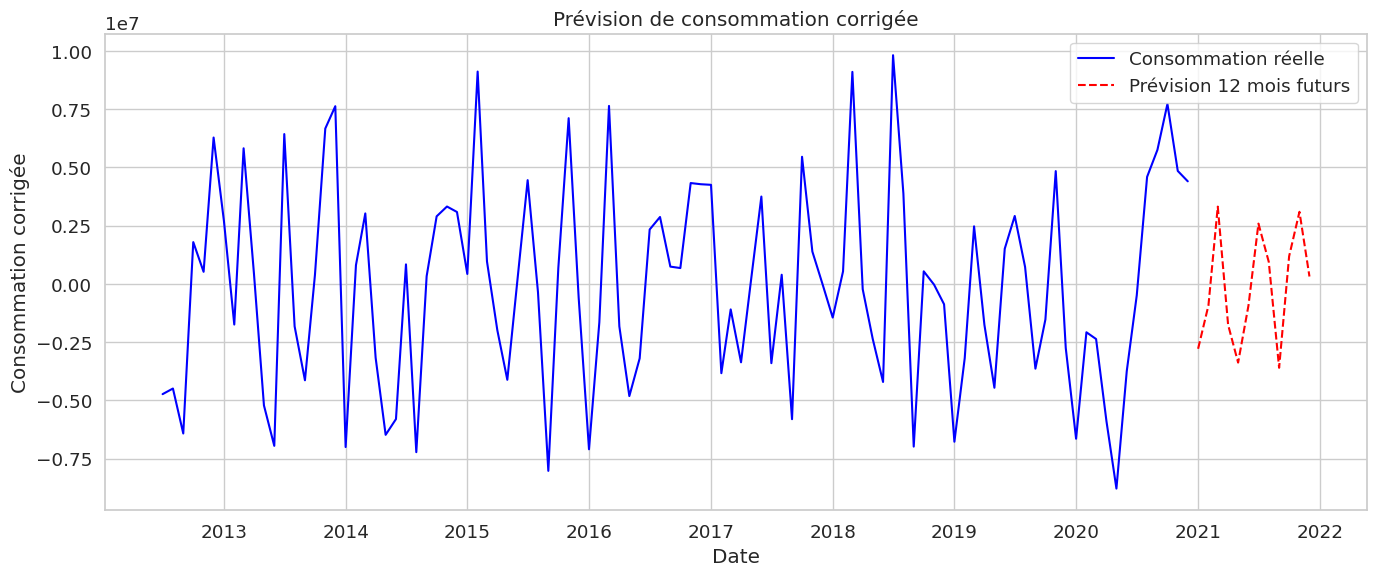

In [50]:
sarima_predictions(stationaryData.reset_index(), savePath='resources/img/sarima_prediction.png')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13076D+01    |proj g|=  1.13899D-01

At iterate    5    f=  1.12726D+01    |proj g|=  3.82917D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.840D-06   1.127D+01
  F =   11.272639956059779     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Pr√©cision de Pr√©vision ann√©e N-2 : 98.72% (MAPE = 1.28%)
√âcart moyen absolu pour Pr√©vision ann√©e N-2 : 3572161.26



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19635D+01    |proj g|=  9.98752D-02

At iterate    5    f=  1.19473D+01    |proj g|=  1.05492D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.866D-07   1.195D+01
  F =   11.947299943128531     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Pr√©cision de Pr√©vision ann√©e N-1 : 98.38% (MAPE = 1.62%)
√âcart moyen absolu pour Pr√©vision ann√©e N-1 : 4765249.48



 This problem is unconstrained.


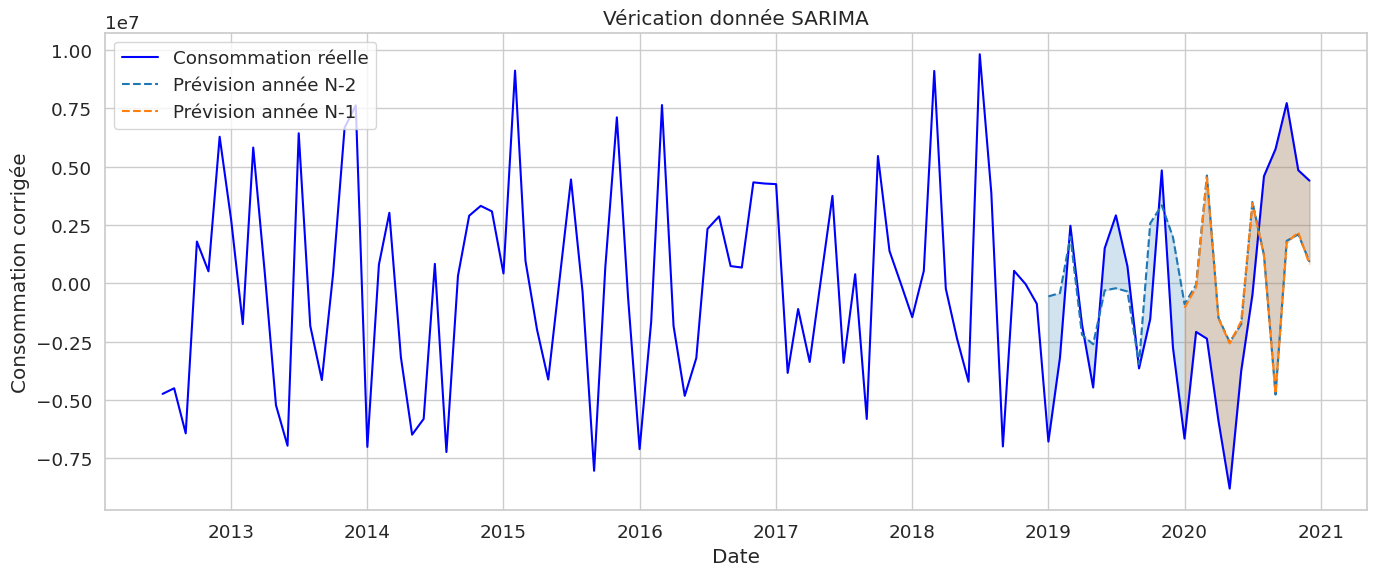

‚è±Ô∏è Pr√©cision de Pr√©vision ann√©e N-2 : 98.72% (MAPE = 1.28%)
‚è±Ô∏è Pr√©cision de Pr√©vision ann√©e N-1 : 98.38% (MAPE = 1.62%)


In [51]:
sarima_predictions(stationaryData.reset_index(), titlePlot='V√©rication donn√©e SARIMA',minYear="2019", maxYear="2020", seperateLines=True, savePath='resources/img/check_sarima_prediction.png')